In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.special import erf, erfc, ive, iv
from scipy.stats import skew, kurtosis

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

In [2]:
def SNR_regularized_delta_source(r,S0,n,lbda,KD,Rcell,epsilon=1):

    r[r==0] =  -1
    
    r_ep = r/(2*epsilon)**0.5
    s_ep = (epsilon/2/lbda**2)**0.5
    
    Erf1  = erf(r_ep-s_ep)
    Erfc2 = erfc(r_ep+s_ep)
    
    fr = 0.5*np.exp(s_ep**2) * (1+Erf1 - np.exp(2*r/lbda)*Erfc2)
    
    Cr = S0 * np.exp(-r/lbda)/r * fr
    
    fp_over_f= ( (8/np.pi/epsilon)**0.5 * np.exp(-(r_ep-s_ep)**2)
                 - 2/lbda * Erfc2*np.exp(2*r/lbda) ) \
                / ( 1 + Erf1 - Erfc2*np.exp(2*r/lbda) )
    
    p = 2*Rcell*np.abs(1/r+1/lbda-fp_over_f)
    
    Cr[r<0] = S0 * ((2/np.pi/epsilon)**0.5-np.exp(s_ep**2)*(1-erf(s_ep))/lbda)
    p[r<0] = 0
    sigma2_p = 8*(Cr + KD)**2/(n*Cr*KD)
    
    return p**2/sigma2_p, Cr

10000 10000 1.0 1.0


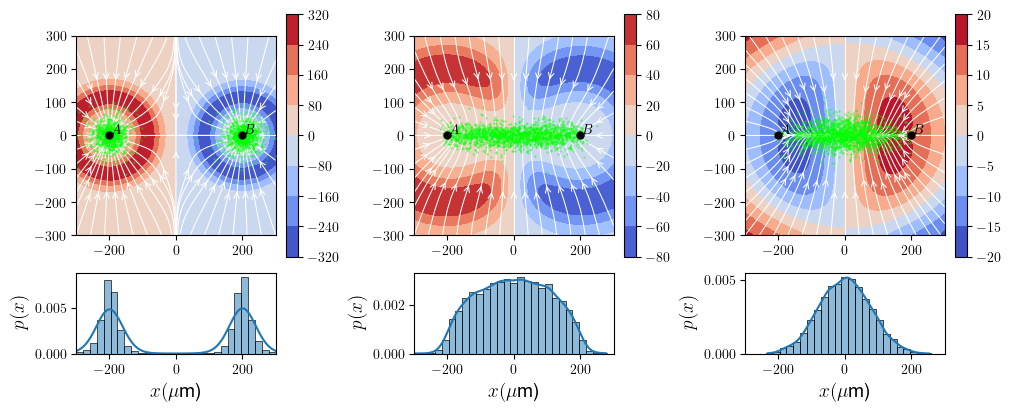

In [3]:
Rcell = 10

dt_r = 0.01
T = 1000.0
Ntraj = 10000

#cell
v0 = 5.0 # cell speed
Rcell = 10.0 # cell radius
Dtheta = 0.4 #0.01 # polarity noise
tau = 2.0 # relaxation rate
L0 = v0*tau

dt= tau*dt_r
nt = int(T/dt)
t = np.linspace(0,T,nt)


# Chemokine A
n = 10000 # number of type A receptors
KD = 1.0 # dissociation constant A
lbda = 50.0 # chemokine lengthscale A 0.05-0.1 nM/s
S0 = 12810.0 # source A size in units of gamma

epsilon=16

x0A,y0A = -200,0 #position source A
x0B,y0B = 200,0 #position source B

nA, KDA, lbdaA, SA = n, KD, lbda, S0
nB, KDB, lbdaB, SB = n, KD, lbda, S0


print(nA,nB,KDA,KDB)

fig, ax = plt.subplots(2,3,figsize=(10,4), width_ratios=[1,1,1], height_ratios=[3,1] ,layout='constrained' ) 

im=[]
vmax= -1e5
vmin = 1e5

lbda_vec = [25.0, 50.0, 100.0]
for i, lbda_i in enumerate(lbda_vec):

    lbdaA = lbda_i
    lbdaB = lbda_i

    lgrid = 300
    xgrid = np.linspace(-lgrid, lgrid,500)
    ygrid = np.linspace(-lgrid, lgrid,500)
    
    X, Y = np.meshgrid(xgrid, ygrid)
    rA = ((X-x0A)**2+(Y-y0A)**2)**0.5
    rB = ((X-x0B)**2+(Y-y0B)**2)**0.5
    
    phiA = np.arctan2(-(Y-y0A),-(X-x0A))
    phiB = np.arctan2(-(Y-y0B),-(X-x0B))

    
    SNRA, CrA = SNR_regularized_delta_source(rA,SA,nA,lbdaA,KDA,Rcell,epsilon)
    SNRB, CrB = SNR_regularized_delta_source(rB,SB,nB,lbdaB,KDB,Rcell,epsilon)
    
    wA = ive(1,SNRA)/ive(0,SNRA)
    wB = ive(1,SNRB)/ive(0,SNRB)
    
    clmap = 'coolwarm' # 'ReYlBu', 'RdBu', 'coolwarm', 'spectral', 'seismic'
    
    dAx = np.cos(phiA)*wA
    dAy = np.sin(phiA)*wA
    dBx = np.cos(phiB)*wB
    dBy = np.sin(phiB)*wB
    dmeanx = np.cos(phiA)*wA + np.cos(phiB)*wB
    dmeany = np.sin(phiA)*wA + np.sin(phiB)*wB

    vmax = np.max(SNRA-SNRB)

    vmin = np.min(SNRA-SNRB)
        
    ax[0,i].set_aspect('equal')
    # im_i = ax[0,i].contourf(X, Y, (dmeanx**2+dmeany**2)**0.5,vmax=2,cmap=clmap)
    im_i = ax[0,i].contourf(X, Y, SNRA-SNRB, cmap='coolwarm',zorder=1)
    im.append(im_i)
    ax[0,i].streamplot(X, Y, dmeanx, dmeany, density=0.5, linewidth=0.75, color='w', arrowstyle='->', arrowsize=1.0, broken_streamlines=False,zorder=2) 
    if np.abs(vmin)>vmax:
        im_i.set_clim(vmin=vmin,vmax=-vmin)
    else:
        im_i.set_clim(vmin=-vmax,vmax=vmax)
    fig.colorbar(im_i,ax=ax[0,i])


    dir = "./data/Anisotropic_sensing/"
    filename = 'N_{0}_v0_{1}_tau_{2}_Dth_{3}_nA_{4}_KDA_{5}_lbdaA_{6}_SA_{7}_nB_{8}_KDB_{9}_lbdaB_{10}_SB_{11}_T_{12}_dt_{13}'.format(Ntraj,v0,tau,Dtheta,nA,KDA,lbdaA,SA,nB,KDB,lbdaB,SB,T,dt_r)
    data = np.loadtxt(dir+"prw2grads_pos_ss_"+filename+".dat")
    x = data[:,0]
    y = data[:,1] 

    
    ax[0,i].scatter(x0A, y0A, marker='o',s=25,c='k',zorder=4)
    ax[0,i].scatter(x0B, y0B, marker='o',s=25,c='k',zorder=4)
    ax[0,i].text(x0A+5, y0A+5, '$A$',zorder=4)
    ax[0,i].text(x0B+5, y0B+5, '$B$',zorder=4)

    ax[0,i].set_xlim([-lgrid,lgrid])
    ax[0,i].set_ylim([-lgrid,lgrid])
    
    
    ax[0,i].scatter(x[::5],y[::5],marker='.',s=0.5,c='lime',zorder=3,alpha=0.8)
    
    
    bins = np.linspace(-300,300,30)
    sns.histplot(data=x, bins=bins, stat='density', kde=True, ax=ax[1,i])

    ax[1,i].set_xlim([-300,300])
    ax[1,i].set_xlabel('$x (\mu$m)', fontsize=14)
    ax[1,i].set_ylabel('$p(x)$', fontsize=14)
    

10000 10000 1.0 1.0


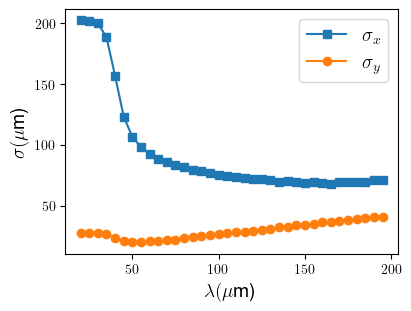

In [4]:
Rcell = 10

dt_r = 0.01
T = 1000.0
Ntraj = 10000

#cell
v0 = 5.0 # cell speed
Rcell = 10.0 # cell radius
Dtheta = 0.4 #0.01 # polarity noise
tau = 2.0 # relaxation rate
L0 = v0*tau

dt= tau*dt_r
nt = int(T/dt)
t = np.linspace(0,T,nt)


# Chemokine A
n = 10000 # number of type A receptors
KD = 1.0 # dissociation constant A
lbda = 50.0 # chemokine lengthscale A 0.05-0.1 nM/s
S0 = 12810.0 # source A size in units of gamma

epsilon=16

x0A,y0A = -200,0 #position source A
x0B,y0B = 200,0 #position source B

nA, KDA, lbdaA, SA = n, KD, lbda, S0
nB, KDB, lbdaB, SB = n, KD, lbda, S0


print(nA,nB,KDA,KDB)

fig, ax = plt.subplots(figsize=(4,3), layout='constrained' ) 


lbda_vec = np.arange(20.0,200,5)
sigma_x = np.zeros(len(lbda_vec))
sigma_y = np.zeros(len(lbda_vec))
for i, lbda_i in enumerate(lbda_vec):

    lbdaA = lbda_i
    lbdaB = lbda_i
    
    dir = "./data/Anisotropic_sensing/"
    filename = 'N_{0}_v0_{1}_tau_{2}_Dth_{3}_nA_{4}_KDA_{5}_lbdaA_{6}_SA_{7}_nB_{8}_KDB_{9}_lbdaB_{10}_SB_{11}_T_{12}_dt_{13}'.format(Ntraj,v0,tau,Dtheta,nA,KDA,lbdaA,SA,nB,KDB,lbdaB,SB,T,dt_r)
    data = np.loadtxt(dir+"prw2grads_pos_ss_"+filename+".dat")
    x = data[:,0]
    y = data[:,1] 

    sigma_x[i] = np.std(x)
    sigma_y[i] = np.std(y)
    
    
ax.plot(lbda_vec,sigma_x, '-s', label='$\sigma_x$')
ax.plot(lbda_vec,sigma_y, '-o', label='$\sigma_y$')

ax.set_xlabel('$\lambda (\mu$m)', fontsize=14)
ax.set_ylabel('$\sigma (\mu$m)', fontsize=14)
ax.legend(fontsize=14)    

10000 10000 1.0 1.0


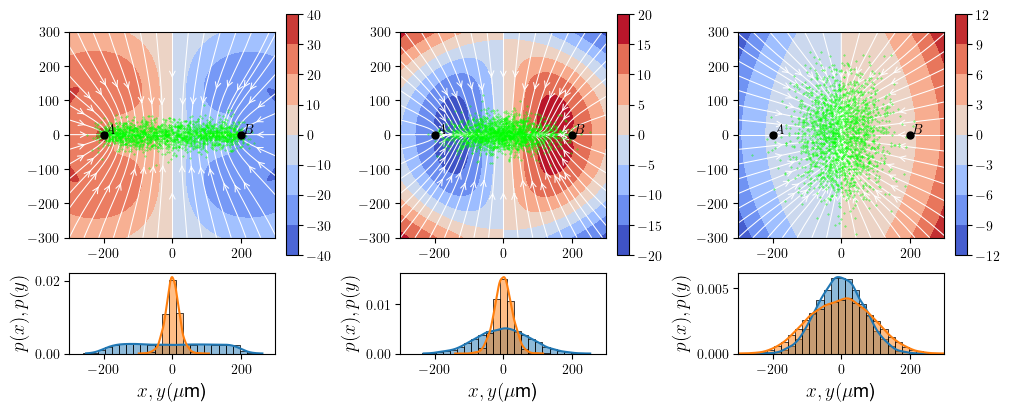

In [5]:
Rcell = 10

dt_r = 0.01
T = 1000.0
Ntraj = 10000

#cell
v0 = 5.0 # cell speed
Rcell = 10.0 # cell radius
Dtheta = 0.4 #0.01 # polarity noise
tau = 2.0 # relaxation rate
L0 = v0*tau

dt= tau*dt_r
nt = int(T/dt)
t = np.linspace(0,T,nt)


# Chemokine A
n = 10000 # number of type A receptors
KD = 1.0 # dissociation constant A
lbda = 100.0 # chemokine lengthscale A 0.05-0.1 nM/s
S0 = 12810.0 # source A size in units of gamma

epsilon=16

x0A,y0A = -200,0 #position source A
x0B,y0B = 200,0 #position source B

nA, KDA, lbdaA, SA = n, KD, lbda, S0
nB, KDB, lbdaB, SB = n, KD, lbda, S0


print(nA,nB,KDA,KDB)

fig, ax = plt.subplots(2,3,figsize=(10,4), width_ratios=[1,1,1], height_ratios=[3,1] ,layout='constrained' ) 


im=[]
vmax= -1e5
vmin = 1e5

S0_vec = [int(10*S0*x)/10 for x in [0.1, 1.0, 50]]
for i, S0_i in enumerate(S0_vec):

    lgrid = 300
    xgrid = np.linspace(-lgrid, lgrid,500)
    ygrid = np.linspace(-lgrid, lgrid,500)
    
    X, Y = np.meshgrid(xgrid, ygrid)
    rA = ((X-x0A)**2+(Y-y0A)**2)**0.5
    rB = ((X-x0B)**2+(Y-y0B)**2)**0.5
    
    phiA = np.arctan2(-(Y-y0A),-(X-x0A))
    phiB = np.arctan2(-(Y-y0B),-(X-x0B))

    
    SNRA, CrA = SNR_regularized_delta_source(rA,S0_i,nA,lbdaA,KDA,Rcell,epsilon)
    SNRB, CrB = SNR_regularized_delta_source(rB,S0_i,nB,lbdaB,KDB,Rcell,epsilon)
    
    wA = ive(1,SNRA)/ive(0,SNRA)
    wB = ive(1,SNRB)/ive(0,SNRB)
    
    clmap = 'coolwarm' # 'ReYlBu', 'RdBu', 'coolwarm', 'spectral', 'seismic'
    
    dAx = np.cos(phiA)*wA
    dAy = np.sin(phiA)*wA
    dBx = np.cos(phiB)*wB
    dBy = np.sin(phiB)*wB
    dmeanx = np.cos(phiA)*wA + np.cos(phiB)*wB
    dmeany = np.sin(phiA)*wA + np.sin(phiB)*wB

    vmax = np.max(SNRA-SNRB)
    vmin = np.min(SNRA-SNRB)
        
    ax[0,i].set_aspect('equal')
    im_i = ax[0,i].contourf(X, Y, SNRA-SNRB, cmap='coolwarm',zorder=1)
    im.append(im_i)
    ax[0,i].streamplot(X, Y, dmeanx, dmeany, density=0.5, linewidth=0.75, color='w', arrowstyle='->', arrowsize=1.0, broken_streamlines=False,zorder=2) 
    if np.abs(vmin)>vmax:
        im_i.set_clim(vmin=vmin,vmax=-vmin)
    else:
        im_i.set_clim(vmin=-vmax,vmax=vmax)
    fig.colorbar(im_i,ax=ax[0,i])

    dir = "./data/Anisotropic_sensing/"
    filename = 'N_{0}_v0_{1}_tau_{2}_Dth_{3}_nA_{4}_KDA_{5}_lbdaA_{6}_SA_{7}_nB_{8}_KDB_{9}_lbdaB_{10}_SB_{11}_T_{12}_dt_{13}'.format(Ntraj,v0,tau,Dtheta,nA,KDA,lbdaA,S0_i,nB,KDB,lbdaB,S0_i,T,dt_r)
    data = np.loadtxt(dir+"prw2grads_pos_ss_"+filename+".dat")
    x = data[:,0]
    y = data[:,1] 

    
    ax[0,i].scatter(x0A, y0A, marker='o',s=25,c='k',zorder=4)
    ax[0,i].scatter(x0B, y0B, marker='o',s=25,c='k',zorder=4)
    ax[0,i].text(x0A+5, y0A+5, '$A$',zorder=4)
    ax[0,i].text(x0B+5, y0B+5, '$B$',zorder=4)

    ax[0,i].set_xlim([-lgrid,lgrid])
    ax[0,i].set_ylim([-lgrid,lgrid])
    
    ax[0,i].scatter(x[::5],y[::5],marker='.',s=0.5,c='lime',zorder=3,alpha=0.8)

    bins = np.linspace(-300,300,30)
    sns.histplot(data=x, bins=bins, stat='density', kde=True, ax=ax[1,i])
    sns.histplot(data=y, bins=bins, stat='density', kde=True, ax=ax[1,i])
    
    ax[1,i].set_xlim([-300,300])
    ax[1,i].set_xlabel('$x,y (\mu$m)',fontsize=14)
    ax[1,i].set_ylabel('$p(x),p(y)$',fontsize=14)


10000 10000 1.0 1.0


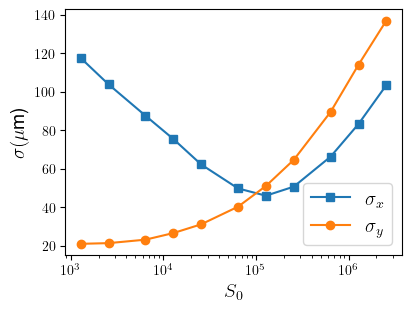

In [6]:
Rcell = 10

dt_r = 0.01
T = 1000.0
Ntraj = 10000

#cell
v0 = 5.0 # cell speed
Rcell = 10.0 # cell radius
Dtheta = 0.4 #0.01 # polarity noise
tau = 2.0 # relaxation rate
L0 = v0*tau

dt= tau*dt_r
nt = int(T/dt)
t = np.linspace(0,T,nt)


# Chemokine A
n = 10000 # number of type A receptors
KD = 1.0 # dissociation constant A
lbda = 100.0 # chemokine lengthscale A 0.05-0.1 nM/s
S0 = 12810.0 # source A size in units of gamma

epsilon=16

x0A,y0A = -200,0 #position source A
x0B,y0B = 200,0 #position source B

nA, KDA, lbdaA, SA = n, KD, lbda, S0
nB, KDB, lbdaB, SB = n, KD, lbda, S0

print(nA,nB,KDA,KDB)

fig, ax = plt.subplots(figsize=(4,3), layout='constrained' ) 

S0_vec = [int(10*S0*x)/10 for x in [0.1,0.2,0.5,1.0,2.0,5.0,10.0,20,50,100,200]]
sigma_x = np.zeros(len(S0_vec))
sigma_y = np.zeros(len(S0_vec))
for i, S0_i in enumerate(S0_vec):
    
    dir = "./data/Anisotropic_sensing/"
    filename = 'N_{0}_v0_{1}_tau_{2}_Dth_{3}_nA_{4}_KDA_{5}_lbdaA_{6}_SA_{7}_nB_{8}_KDB_{9}_lbdaB_{10}_SB_{11}_T_{12}_dt_{13}'.format(Ntraj,v0,tau,Dtheta,nA,KDA,lbdaA,S0_i,nB,KDB,lbdaB,S0_i,T,dt_r)
    data = np.loadtxt(dir+"prw2grads_pos_ss_"+filename+".dat")
    x = data[:,0]
    y = data[:,1] 

    sigma_x[i] = np.std(x)
    sigma_y[i] = np.std(y)

    
ax.plot(S0_vec,sigma_x, '-s', label='$\sigma_x$')
ax.plot(S0_vec,sigma_y, '-o', label='$\sigma_y$')
ax.set_xscale('log')
ax.set_xlabel('$S_0$', fontsize=14)
ax.set_ylabel('$\sigma (\mu$m)', fontsize=14)
ax.legend(fontsize=14)        
